In [1]:
!pip install 'imantics==0.1.12'
!pip install 'torch==1.11.0'
!pip install 'torchvision==0.12.0+cu113'
!pip install 'matplotlib==3.5.1'

In [17]:
import onnxruntime as ort
import argparse
import cv2
import numpy as np
import torch
import torch.nn.functional as F
# from cython_nms import nms as cnms
from itertools import product
from matplotlib import pyplot as plt
from imantics import Polygons, Mask

# Following parameters need to be the same as in training -> could save this as metadata in model training
IMG_SIZE = 544  
SCALES = [int(IMG_SIZE / 544 * aa) for aa in (24, 48, 96, 192, 384)]
ASPECT_RATIOS = [1, 1 / 2, 2]
NMS_SCORE_THRE = 0.05
TOP_K = 200
NMS_IOU_THRE = 0.5
MAX_DETECTIONS = 100

SAVE_LINCOMB = False
VISUAL_THRE = 0  # put > 0 to apply visual threshold scores
CUDA = torch.cuda.is_available()
CUDA = False
NO_CROP = False
WEIGHT = './onnx_files/dewulf_swin_tiny.onnx'
IMG_PATH = "./data/dewulf_resized/images_val/20211013133809_NM_0302547_0161155484_1280_0720_25_04194304_0000000deroo-265_08_2109160002_04_206_0000000_V02_000_E02_0_f_30.jpg"

In [18]:
def normalize_and_toRGB(img, norm_mean, norm_std):
    img = (img - norm_mean) / norm_std
    img = img[:, :, (2, 1, 0)]
    img = np.transpose(img, (2, 0, 1))
    return img

def crop_numpy(masks, boxes, padding=1):
    h, w, n = masks.shape
    x1, x2 = sanitize_coordinates_numpy(boxes[:, 0], boxes[:, 2], w, padding)
    y1, y2 = sanitize_coordinates_numpy(boxes[:, 1], boxes[:, 3], h, padding)

    rows = np.tile(np.arange(w)[None, :, None], (h, 1, n))
    cols = np.tile(np.arange(h)[:, None, None], (1, w, n))

    masks_left = rows >= (x1.reshape(1, 1, -1))
    masks_right = rows < (x2.reshape(1, 1, -1))
    masks_up = cols >= (y1.reshape(1, 1, -1))
    masks_down = cols < (y2.reshape(1, 1, -1))

    crop_mask = masks_left * masks_right * masks_up * masks_down

    return masks * crop_mask

def box_iou(box_a, box_b):
    """
    Compute the IoU of two sets of boxes.
    Args:
        box_a: (tensor) Ground truth bounding boxes, Shape: [num_objects,4]
        box_b: (tensor) Prior boxes from priorbox layers, Shape: [num_priors,4]
    Return:
        jaccard overlap: (tensor) Shape: [box_a.size(0), box_b.size(0)]
    """
    use_batch = True
    if box_a.dim() == 2:
        use_batch = False
        box_a = box_a[None, ...]
        box_b = box_b[None, ...]

    (n, A), B = box_a.shape[:2], box_b.shape[1]
    # add a dimension
    box_a = box_a[:, :, None, :].expand(n, A, B, 4)
    box_b = box_b[:, None, :, :].expand(n, A, B, 4)

    max_xy = torch.min(box_a[..., 2:], box_b[..., 2:])
    min_xy = torch.max(box_a[..., :2], box_b[..., :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    inter_area = inter[..., 0] * inter[..., 1]

    area_a = (box_a[..., 2] - box_a[..., 0]) * (box_a[..., 3] - box_a[..., 1])
    area_b = (box_b[..., 2] - box_b[..., 0]) * (box_b[..., 3] - box_b[..., 1])

    out = inter_area / (area_a + area_b - inter_area)
    return out if use_batch else out.squeeze(0)


def box_iou_numpy(box_a, box_b):
    (n, A), B = box_a.shape[:2], box_b.shape[1]
    # add a dimension
    box_a = np.tile(box_a[:, :, None, :], (1, 1, B, 1))
    box_b = np.tile(box_b[:, None, :, :], (1, A, 1, 1))

    max_xy = np.minimum(box_a[..., 2:], box_b[..., 2:])
    min_xy = np.maximum(box_a[..., :2], box_b[..., :2])
    inter = np.clip((max_xy - min_xy), a_min=0, a_max=100000)
    inter_area = inter[..., 0] * inter[..., 1]

    area_a = (box_a[..., 2] - box_a[..., 0]) * (box_a[..., 3] - box_a[..., 1])
    area_b = (box_b[..., 2] - box_b[..., 0]) * (box_b[..., 3] - box_b[..., 1])

    return inter_area / (area_a + area_b - inter_area)

def pad_to_square(img, norm_mean, masks=None, boxes=None, during_training=False):
    img_h, img_w = img.shape[:2]
    if img_h == img_w:
        return (img, masks, boxes) if during_training else img
    else:
        pad_size = max(img_h, img_w)
        pad_img = np.zeros((pad_size, pad_size, 3), dtype='float32')
        pad_img[:, :, :] = norm_mean

        if during_training:
            pad_masks = np.zeros((masks.shape[0], pad_size, pad_size), dtype='float32')

            if img_h < img_w:
                random_y1 = random.randint(0, img_w - img_h)
                pad_img[random_y1: random_y1 + img_h, :, :] = img
                pad_masks[:, random_y1: random_y1 + img_h, :] = masks
                boxes[:, [1, 3]] += random_y1

            if img_h > img_w:
                random_x1 = random.randint(0, img_h - img_w)
                pad_img[:, random_x1: random_x1 + img_w, :] = img
                pad_masks[:, :, random_x1: random_x1 + img_w] = masks
                boxes[:, [0, 2]] += random_x1

            return pad_img, pad_masks, boxes
        else:
            pad_img[0: img_h, 0: img_w, :] = img
            return pad_img
        
        
def make_anchors(conv_h, conv_w, scale):
    prior_data = []
    # Iteration order is important (it has to sync up with the convout)
    for j, i in product(range(conv_h), range(conv_w)):
        # + 0.5 because priors are in center
        x = (i + 0.5) / conv_w
        y = (j + 0.5) / conv_h

        for ar in ASPECT_RATIOS:
            ar = np.sqrt(ar)
            w = scale * ar / IMG_SIZE
            h = scale / ar / IMG_SIZE

            prior_data += [x, y, w, h]

    return prior_data

# Don't seem to need these, but keep them in for safety

In [19]:
# def traditional_nms(boxes, masks, scores, cfg):
#     num_classes = scores.size(0)
# 
#     idx_lst, cls_lst, scr_lst = [], [], []
# 
#     # Multiplying by max_size is necessary because of how cnms computes its area and intersections
#     boxes = boxes * IMG_SIZE
# 
#     for _cls in range(num_classes):
#         cls_scores = scores[_cls, :]
#         conf_mask = cls_scores > cfg.nms_score_thre
#         idx = torch.arange(cls_scores.size(0), device=boxes.device)
# 
#         cls_scores = cls_scores[conf_mask]
#         idx = idx[conf_mask]
# 
#         if cls_scores.size(0) == 0:
#             continue
# 
#         preds = torch.cat([boxes[conf_mask], cls_scores[:, None]], dim=1).cpu().numpy()
#         keep = cnms(preds, cfg.nms_iou_thre)
#         keep = torch.tensor(keep, device=boxes.device).long()
# 
#         idx_lst.append(idx[keep])
#         cls_lst.append(keep * 0 + _cls)
#         scr_lst.append(cls_scores[keep])
# 
#     idx = torch.cat(idx_lst, dim=0)
#     class_ids = torch.cat(cls_lst, dim=0)
#     scores = torch.cat(scr_lst, dim=0)
# 
#     scores, idx2 = scores.sort(0, descending=True)
#     idx2 = idx2[:cfg.max_detections]
#     scores = scores[:cfg.max_detections]
# 
#     idx = idx[idx2]
#     class_ids = class_ids[idx2]
# 
#     # Undo the multiplication above
#     return boxes[idx] / IMG_SIZE, masks[idx], class_ids, scores


# def nms(class_pred, box_pred, coef_pred, proto_out, anchors, cfg):
#     class_p = class_pred.squeeze()  # [19248, 81]
#     box_p = box_pred.squeeze()  # [19248, 4]
#     coef_p = coef_pred.squeeze()  # [19248, 32]
#     proto_p = proto_out.squeeze()  # [138, 138, 32]
# 
#     if isinstance(anchors, list):
#         anchors = torch.tensor(anchors, device=class_p.device).reshape(-1, 4)
# 
#     class_p = class_p.transpose(1, 0).contiguous()  # [81, 19248]
# 
#     # exclude the background class
#     class_p = class_p[1:, :]
#     # get the max score class of 19248 predicted boxes
#     class_p_max, _ = torch.max(class_p, dim=0)  # [19248]
# 
#     # filter predicted boxes according the class score
#     keep = (class_p_max > cfg.nms_score_thre)
#     class_thre = class_p[:, keep]
#     box_thre, anchor_thre, coef_thre = box_p[keep, :], anchors[keep, :], coef_p[keep, :]
# 
#     # decode boxes
#     box_thre = torch.cat((anchor_thre[:, :2] + box_thre[:, :2] * 0.1 * anchor_thre[:, 2:],
#                           anchor_thre[:, 2:] * torch.exp(box_thre[:, 2:] * 0.2)), 1)
#     box_thre[:, :2] -= box_thre[:, 2:] / 2
#     box_thre[:, 2:] += box_thre[:, :2]
# 
#     box_thre = torch.clip(box_thre, min=0., max=1.)
# 
#     if class_thre.shape[1] == 0:
#         return None, None, None, None, None
#     else:
#         if not cfg.traditional_nms:
#             box_thre, coef_thre, class_ids, class_thre = fast_nms(box_thre, coef_thre, class_thre, cfg)
#         else:
#             box_thre, coef_thre, class_ids, class_thre = traditional_nms(box_thre, coef_thre, class_thre, cfg)
# 
#         return class_ids, class_thre, box_thre, coef_thre, proto_p
# 
# def fast_nms(box_thre, coef_thre, class_thre, cfg):
#     class_thre, idx = class_thre.sort(1, descending=True)  # [80, 64 (the number of kept boxes)]
# 
#     idx = idx[:, :cfg.top_k]
#     class_thre = class_thre[:, :cfg.top_k]
# 
#     num_classes, num_dets = idx.size()
#     box_thre = box_thre[idx.reshape(-1), :].reshape(num_classes, num_dets, 4)  # [80, 64, 4]
#     coef_thre = coef_thre[idx.reshape(-1), :].reshape(num_classes, num_dets, -1)  # [80, 64, 32]
# 
#     iou = box_iou(box_thre, box_thre)
#     iou.triu_(diagonal=1)
#     iou_max, _ = iou.max(dim=1)
# 
#     # Now just filter out the ones higher than the threshold
#     keep = (iou_max <= cfg.nms_iou_thre)
# 
#     # Assign each kept detection to its corresponding class
#     class_ids = torch.arange(num_classes, device=box_thre.device)[:, None].expand_as(keep)
# 
#     class_ids, box_nms, coef_nms, class_nms = class_ids[keep], box_thre[keep], coef_thre[keep], class_thre[keep]
# 
#     # Only keep the top cfg.max_num_detections highest scores across all classes
#     class_nms, idx = class_nms.sort(0, descending=True)
# 
#     idx = idx[:cfg.max_detections]
#     class_nms = class_nms[:cfg.max_detections]
# 
#     class_ids = class_ids[idx]
#     box_nms = box_nms[idx]
#     coef_nms = coef_nms[idx]
# 
#     return box_nms, coef_nms, class_ids, class_nms
# 


In [20]:
def fast_nms_numpy(box_thre, coef_thre, class_thre):
    # descending sort
    idx = np.argsort(-class_thre, axis=1)
    class_thre = np.sort(class_thre, axis=1)[:, ::-1]

    idx = idx[:, :TOP_K]
    class_thre = class_thre[:, :TOP_K]

    num_classes, num_dets = idx.shape
    box_thre = box_thre[idx.reshape(-1), :].reshape(num_classes, num_dets, 4)  # [80, 64, 4]
    coef_thre = coef_thre[idx.reshape(-1), :].reshape(num_classes, num_dets, -1)  # [80, 64, 32]

    iou = box_iou_numpy(box_thre, box_thre)
    iou = np.triu(iou, k=1)
    iou_max = np.max(iou, axis=1)

    # Now just filter out the ones higher than the threshold
    keep = (iou_max <= NMS_IOU_THRE)

    # Assign each kept detection to its corresponding class
    class_ids = np.tile(np.arange(num_classes)[:, None], (1, keep.shape[1]))

    class_ids, box_nms, coef_nms, class_nms = class_ids[keep], box_thre[keep], coef_thre[keep], class_thre[keep]

    # Only keep the top max_num_detections highest scores across all classes
    idx = np.argsort(-class_nms, axis=0)
    class_nms = np.sort(class_nms, axis=0)[::-1]

    idx = idx[:MAX_DETECTIONS]
    class_nms = class_nms[:MAX_DETECTIONS]

    class_ids = class_ids[idx]
    box_nms = box_nms[idx]
    coef_nms = coef_nms[idx]

    return box_nms, coef_nms, class_ids, class_nms



def nms_numpy(class_pred, box_pred, coef_pred, proto_out, anchors):
    class_p = class_pred.squeeze()  # [19248, 81]
    box_p = box_pred.squeeze()  # [19248, 4]
    coef_p = coef_pred.squeeze()  # [19248, 32]
    proto_p = proto_out.squeeze()  # [138, 138, 32]
    anchors = np.array(anchors).reshape(-1, 4)

    class_p = class_p.transpose(1, 0)
    # exclude the background class
    class_p = class_p[1:, :]
    # get the max score class of 19248 predicted boxes

    class_p_max = np.max(class_p, axis=0)  # [19248]

    # filter predicted boxes according the class score
    keep = (class_p_max > NMS_SCORE_THRE)
    class_thre = class_p[:, keep]

    box_thre, anchor_thre, coef_thre = box_p[keep, :], anchors[keep, :], coef_p[keep, :]

    # decode boxes
    box_thre = np.concatenate((anchor_thre[:, :2] + box_thre[:, :2] * 0.1 * anchor_thre[:, 2:],
                               anchor_thre[:, 2:] * np.exp(box_thre[:, 2:] * 0.2)), axis=1)
    box_thre[:, :2] -= box_thre[:, 2:] / 2
    box_thre[:, 2:] += box_thre[:, :2]

    if class_thre.shape[1] == 0:
        return None, None, None, None, None
    else:
        # assert not cfg.traditional_nms, 'Traditional nms is not supported with numpy.'
        box_thre, coef_thre, class_ids, class_thre = fast_nms_numpy(box_thre, coef_thre, class_thre)
        return class_ids, class_thre, box_thre, coef_thre, proto_p

def after_nms_numpy(ids_p, class_p, box_p, coef_p, proto_p, img_h, img_w):
    def np_sigmoid(x):
        return 1 / (1 + np.exp(-x))

    if ids_p is None:
        return None, None, None, None

    if VISUAL_THRE > 0:
        keep = class_p >= visual_thre
        if not keep.any():
            return None, None, None, None

        ids_p = ids_p[keep]
        class_p = class_p[keep]
        box_p = box_p[keep]
        coef_p = coef_p[keep]

    assert not SAVE_LINCOMB, 'save_lincomb is not supported in onnx mode.'

    masks = np_sigmoid(np.matmul(proto_p, coef_p.T))

    if not NO_CROP :  # Crop masks by box_p
        masks = crop_numpy(masks, box_p)

    ori_size = max(img_h, img_w)
    masks = cv2.resize(masks, (ori_size, ori_size), interpolation=cv2.INTER_LINEAR)

    if masks.ndim == 2:
        masks = masks[:, :, None]

    masks = np.transpose(masks, (2, 0, 1))
    masks = masks > 0.5  # Binarize the masks because of interpolation.
    masks = masks[:, 0: img_h, :] if img_h < img_w else masks[:, :, 0: img_w]

    box_p *= ori_size
    box_p = box_p.astype('int32')

    return ids_p, class_p, box_p, masks

def draw_lincomb(proto_data, masks, img_name):
    for kdx in range(1):
        jdx = kdx + 0
        coeffs = masks[jdx, :].cpu().numpy()
        idx = np.argsort(-np.abs(coeffs))

        coeffs_sort = coeffs[idx]
        arr_h, arr_w = (4, 8)
        p_h, p_w, _ = proto_data.size()
        arr_img = np.zeros([p_h * arr_h, p_w * arr_w])
        arr_run = np.zeros([p_h * arr_h, p_w * arr_w])

        for y in range(arr_h):
            for x in range(arr_w):
                i = arr_w * y + x

                if i == 0:
                    running_total = proto_data[:, :, idx[i]].cpu().numpy() * coeffs_sort[i]
                else:
                    running_total += proto_data[:, :, idx[i]].cpu().numpy() * coeffs_sort[i]

                running_total_nonlin = (1 / (1 + np.exp(-running_total)))

                arr_img[y * p_h:(y + 1) * p_h, x * p_w:(x + 1) * p_w] = (proto_data[:, :, idx[i]] / torch.max(
                    proto_data[:, :, idx[i]])).cpu().numpy() * coeffs_sort[i]
                arr_run[y * p_h:(y + 1) * p_h, x * p_w:(x + 1) * p_w] = (running_total_nonlin > 0.5).astype(np.float)

        arr_img = ((arr_img + 1) * 127.5).astype('uint8')
        arr_img = cv2.applyColorMap(arr_img, cv2.COLORMAP_WINTER)
        cv2.imwrite(f'results/images/lincomb_{img_name}', arr_img)
        
def sanitize_coordinates_numpy(_x1, _x2, img_size, padding=0):
    _x1 = _x1 * img_size
    _x2 = _x2 * img_size

    x1 = np.minimum(_x1, _x2)
    x2 = np.maximum(_x1, _x2)
    x1 = np.clip(x1 - padding, a_min=0, a_max=1000000)
    x2 = np.clip(x2 + padding, a_min=0, a_max=img_size)

    return x1, x2

# This is where the magic happens

## Reading in image

In [21]:
input_img = cv2.imread(IMG_PATH)
img_rgb = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)

print('Original Dimensions: ',input_img.shape)

img_h, img_w = input_img.shape[0:2]

Original Dimensions:  (360, 640, 3)


## Preprocessing image

In [22]:
# from config import norm_mean, norm_std
# norm_mean and norm_std need to be the same as in training -> could save this as metadata in model training
norm_mean = np.array([103.94, 116.78, 123.68], dtype=np.float32)
norm_std = np.array([57.38, 57.12, 58.40], dtype=np.float32)

resized = pad_to_square(input_img.astype('float32'), norm_mean)
resized = cv2.resize(resized, (IMG_SIZE, IMG_SIZE))
resized = normalize_and_toRGB(resized, norm_mean, norm_std)

batch = np.array([resized])
print("Batch size/shape: ", batch.shape)

Batch size/shape:  (1, 3, 544, 544)


## Inference

In [23]:
providers = ['CUDAExecutionProvider', 'CPUExecutionProvider'] if CUDA else ['CPUExecutionProvider']
sess = ort.InferenceSession(WEIGHT, providers=providers)
input_name = sess.get_inputs()[0].name

In [24]:
class_p, box_p, coef_p, proto_p = sess.run(None, {input_name: batch})

## Postprocessing

In [25]:
anchors = []
fpn_fm_shape = [np.math.ceil(IMG_SIZE / stride) for stride in (8, 16, 32, 64, 128)]
for i, size in enumerate(fpn_fm_shape):
    anchors += make_anchors(size, size, SCALES[i])

In [26]:
ids_p, class_p, box_p, coef_p, proto_p = nms_numpy(class_p, box_p, coef_p, proto_p, anchors)

In [27]:
ids_p, class_p, boxes_p, masks_p = after_nms_numpy(ids_p, class_p, box_p, coef_p, proto_p, img_h, img_w)

## Create polygons from masks and draw results

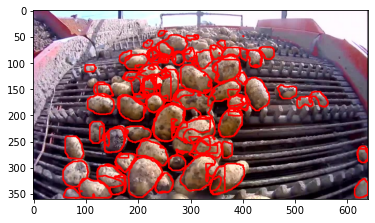

In [28]:
img_copy = img_rgb.copy()
for mask in masks_p:
    polygons = Mask(mask).polygons()
    for polygon in polygons.points:
        pol_vert = polygon.reshape((-1,1,2))
        cv2.polylines(img_copy, [pol_vert], isClosed = True, color = (255, 0, 0), thickness=2)
plt.imshow(img_copy)

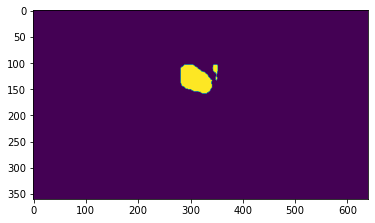

In [29]:
plt.imshow(masks_p[0])